In [1]:
# Script to generate annotated example micrographs for the vesicle picker manuscript
from vesicle_picker import helpers, preprocess, generate_masks, postprocess, external_import, external_export, funcs_mrcio
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy

# Import the example mrc -- this is the best one in example_micrographs.txt
image_fullres, header = helpers.import_mrc("vesicles_240/raw_mrc/16294215750158436139.mrc")

(-0.5, 1023.5, 1023.5, -0.5)

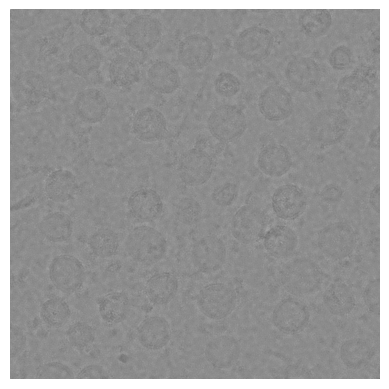

In [2]:
# Use the preprocess module to get micrograph ready for segmentation
preprocessed_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "bilateral",
                                                           d = 17,
                                                           sigmaColor=51,
                                                           sigmaSpace=51)

# Display the preprocessed micrograph
plt.imshow(preprocessed_micrograph, cmap="Greys_r")
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

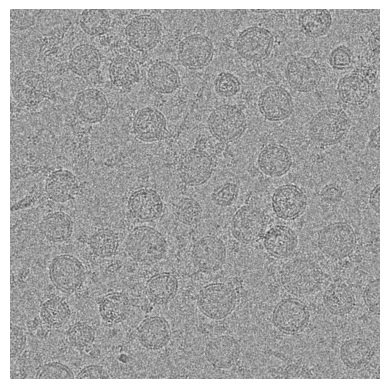

In [3]:
# Get a nice visual of the unprocessed micrograph and save it high res
display_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)

# Display the preprocessed micrograph
plt.imshow(display_micrograph, cmap="Greys_r")
plt.axis('off')

In [4]:
# Use the generate_masks module to perform automatic image segmentation

# Initialize the model
model = generate_masks.initialize_model(model_weights_path = "../sam_vit_h_4b8939.pth", device='cuda:0')

In [5]:
# Generate masks with user-optimized parameters
masks = generate_masks.generate_masks(preprocessed_micrograph, model, 
    points_per_side=36,
    points_per_batch=16,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    crop_nms_thresh=0.5,
    min_mask_region_area=100,
    psize=1.03,
    downsample=4)

In [6]:
# Use the postprocess module to compute statistics on the vesicles
postprocessed_masks = postprocess.postprocess_masks(masks, 
                              [postprocess.find_mask_intensity, postprocess.find_contour, postprocess.find_roundness, postprocess.fit_ellipse], 
                              preprocessed_micrograph)

In [7]:
# Filter these vesicles based on min and max values recorded in 'filters.ini'
filtered_masks = postprocess.apply_filters(postprocessed_masks, "filters.ini")

# Use the extract_statistics function to generate Pandas Dataframes of the postprocessed values, for downstream visualizations.
# See `vesicle_diagnostics.ipynb` for more details on how to do this for a collection of micrographs.
unfiltered_dataset, filtered_dataset = postprocess.extract_statistics(postprocessed_masks, "filters.ini")

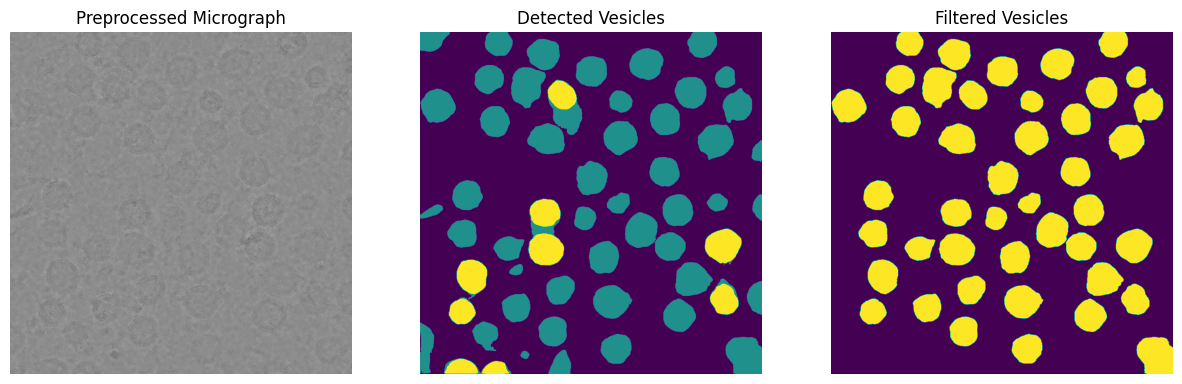

In [8]:
# Create a figure with three subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image in the first subplot
axes[0].imshow(preprocessed_micrograph, cmap="Greys_r")
axes[0].set_title('Preprocessed Micrograph')

# Plot the second image in the second subplot
axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
axes[1].set_title('Detected Vesicles')

# # Plot the third image in the third subplot
axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
axes[2].set_title('Filtered Vesicles')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

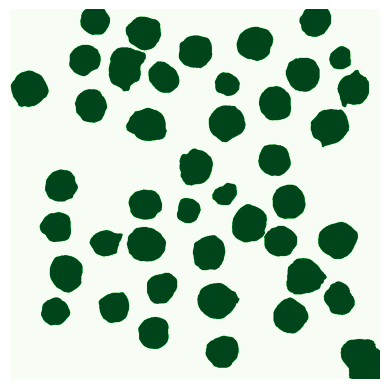

In [9]:
# Show the masks
plt.imshow(helpers.sum_masks(filtered_masks, 'segmentation'), cmap="Greens")
plt.axis('off')
plt.savefig("fig2/16294215750158436139_interior_mask.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

In [12]:
helpers.sum_masks(filtered_masks, 'segmentation')[int(filtered_masks[0]['bbox'][0]):int(filtered_masks[0]['bbox'][0]+160),int(filtered_masks[0]['bbox'][1]+10):int(filtered_masks[0]['bbox'][1]+170)].shape

(160, 160)

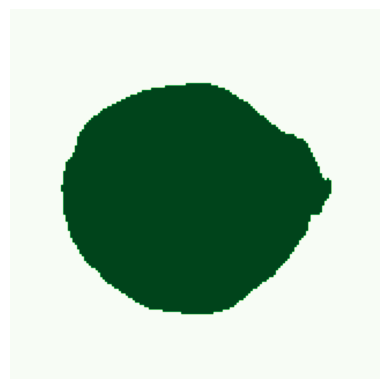

In [33]:
# Find an individual vesicle image
plt.imshow(helpers.sum_masks(filtered_masks, 'segmentation')[int(filtered_masks[0]['bbox'][0]):int(filtered_masks[0]['bbox'][0]+160),int(filtered_masks[0]['bbox'][1]+10):int(filtered_masks[0]['bbox'][1]+170)], cmap="Greens")
plt.axis('off')
plt.savefig("fig2/16294215750158436139_filtered_vesicle_0_interior_mask.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

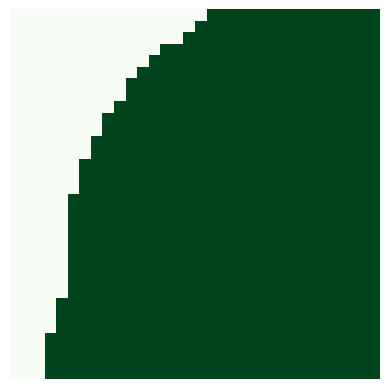

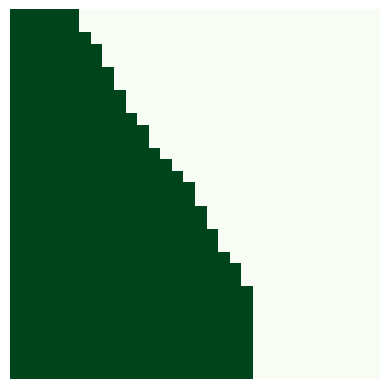

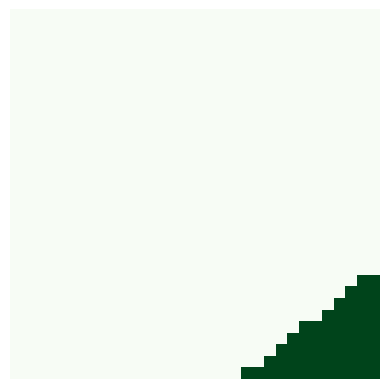

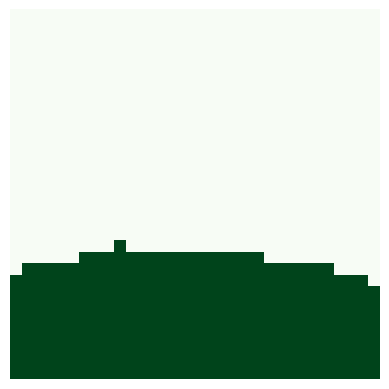

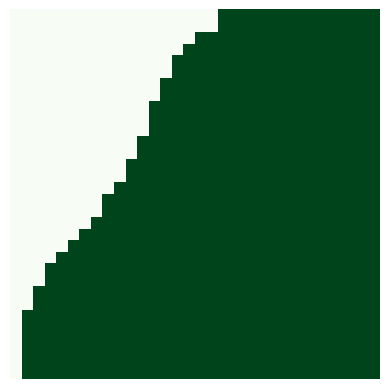

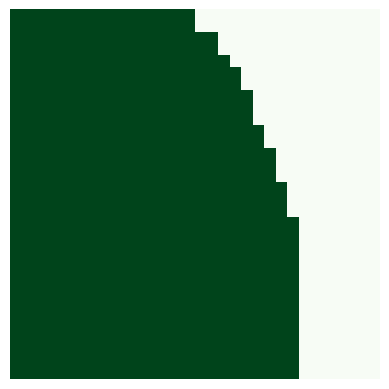

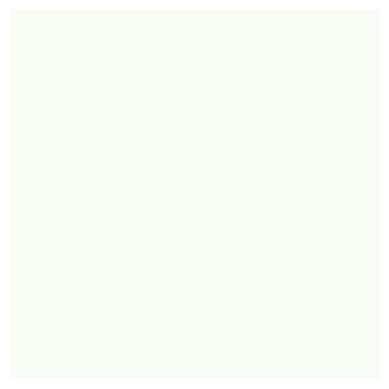

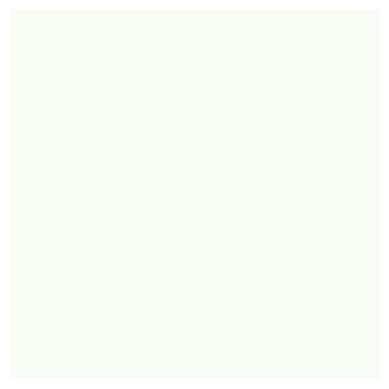

In [73]:
# Break the composite mask into patches with blockshaped
pick_mask = helpers.sum_masks(filtered_masks, 'segmentation')
split_pick_mask = helpers.blockshaped(pick_mask, 32, 32)

#Pick 8 example patches--0,1,4,5,6,7,27,28
# for i in range(32):
#     print(i)
#     plt.imshow(split_pick_mask[i], cmap="Greens")
#     plt.axis('off')
#     plt.show()

# Save the example patches
example_patches = split_pick_mask[(6,8,10,11,25,27,28,29),:,:]
for i in range(8):
    plt.imshow(example_patches[i,:,:], cmap="Greens")
    plt.axis('off')
    plt.show()


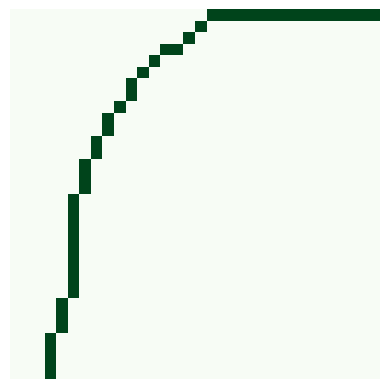

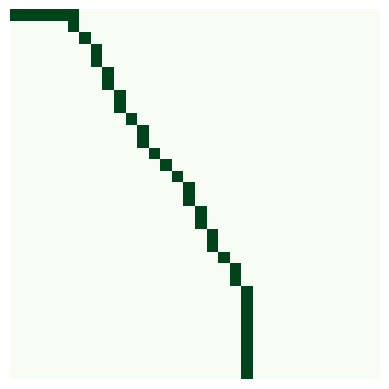

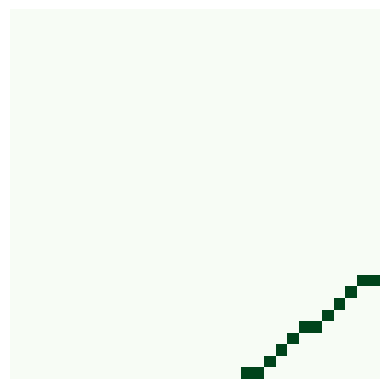

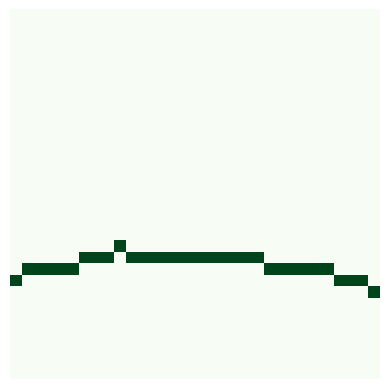

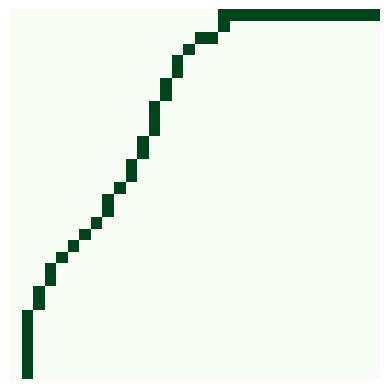

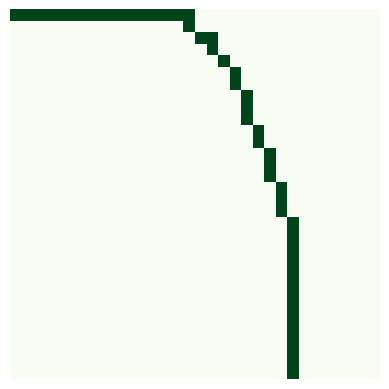

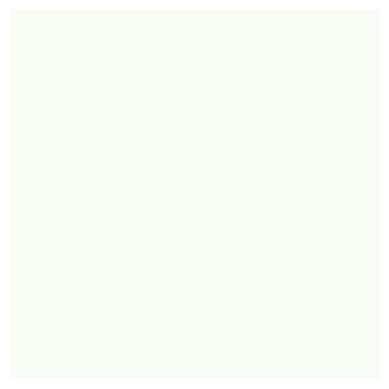

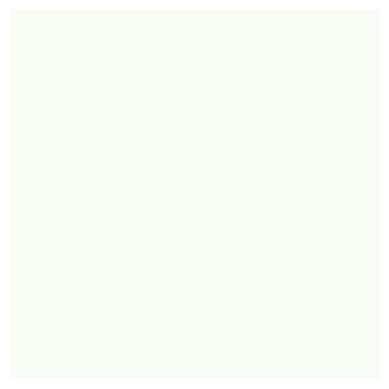

In [74]:
# Break the composite mask into patches with blockshaped
pick_mask = helpers.sum_masks(filtered_masks, 'edge')
split_pick_mask = helpers.blockshaped(pick_mask, 32, 32)

#Pick 8 example patches--0,1,4,5,6,7,27,28
# for i in range(32):
#     print(i)
#     plt.imshow(split_pick_mask[i], cmap="Greens")
#     plt.axis('off')
#     plt.show()

# Save the example patches
example_patches = split_pick_mask[(6,8,10,11,25,27,28,29),:,:]
for i in range(8):
    plt.imshow(example_patches[i,:,:], cmap="Greens")
    plt.axis('off')
    plt.show()


In [75]:
# In each mask, if the sum of the mask is greater than zero (i.e. if there is an edge)
# select the pick closest to the center by setting all other values in the mask to zero
for i in range(example_patches.shape[0]):
    this_patch = np.copy(example_patches[i,:,:])
    if np.sum(this_patch)>0:
        # plt.imshow(example_patches[i,:,:])
        # plt.show()
        #print(this_patch)
        #print(np.argwhere(this_patch))
        best_indices = np.argwhere(this_patch)[np.argmin(np.sum((np.argwhere(this_patch) - 32/2)**2, axis=1))]
        #print(best_indices)
        this_patch = np.zeros(this_patch.shape)
        this_patch[best_indices[0], best_indices[1]] = 1
        example_patches[i,:,:] = this_patch
        # plt.imshow(example_patches[i,:,:])
        # plt.show()

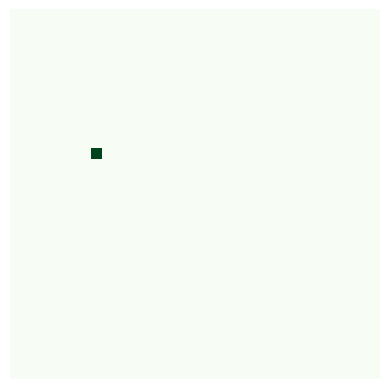

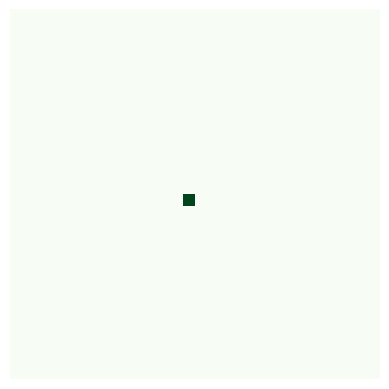

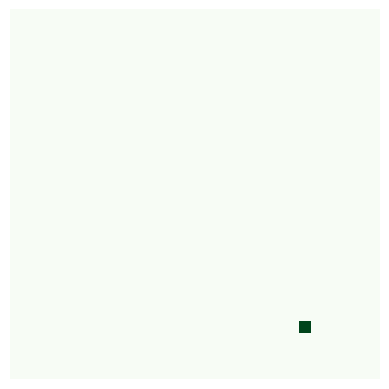

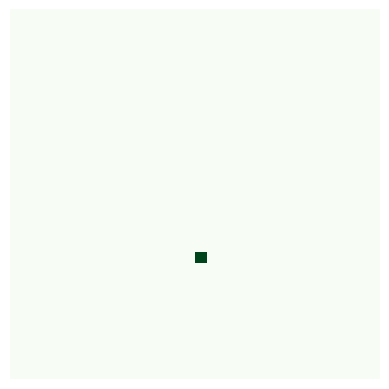

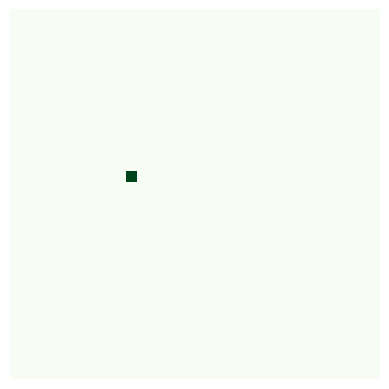

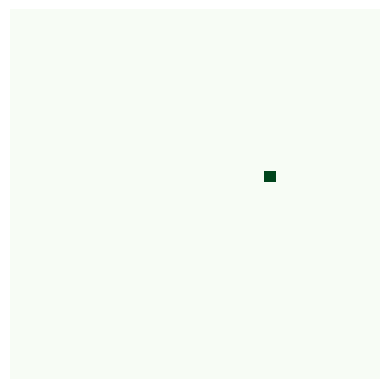

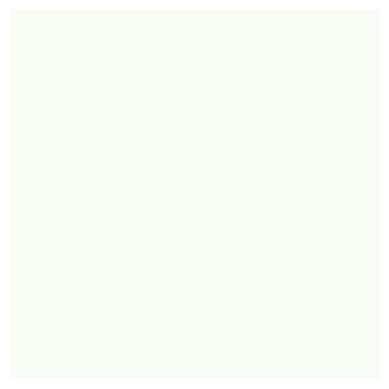

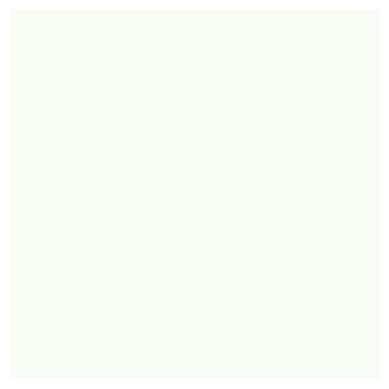

In [76]:
for i in range(8):
    plt.imshow(example_patches[i,:,:], cmap="Greens")
    plt.axis('off')
    plt.show()

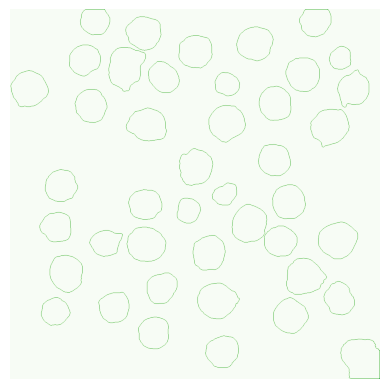

In [100]:
# Show the masks
plt.imshow(helpers.sum_masks(filtered_masks, 'edge'), cmap="Greens")
plt.axis('off')
plt.savefig("fig2/16294215750158436139_edge_mask.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

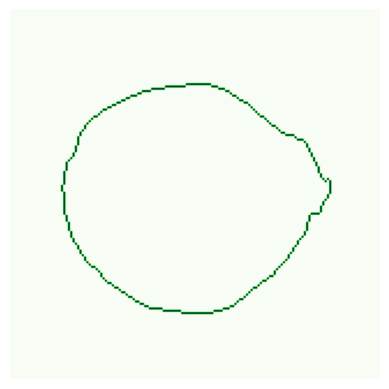

In [34]:
# Find an individual vesicle image
plt.imshow(helpers.sum_masks(filtered_masks, 'edge')[int(filtered_masks[0]['bbox'][0]):int(filtered_masks[0]['bbox'][0]+160),int(filtered_masks[0]['bbox'][1]+10):int(filtered_masks[0]['bbox'][1]+170)], cmap="Greens")
plt.axis('off')
plt.savefig("fig2/16294215750158436139_filtered_vesicle_0_edge_mask.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

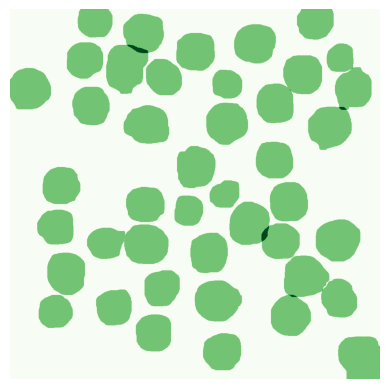

In [76]:
# Dilate the masks and find the edge
dilated_masks = postprocess.dilate_masks(copy.deepcopy(filtered_masks), 30, 1.03, 4)
# dilated_masks = postprocess.postprocess_masks(dilated_masks, 
#                               [postprocess.find_mask_intensity, postprocess.find_contour, postprocess.find_roundness, postprocess.fit_ellipse], 
#                               preprocessed_micrograph)

plt.imshow(helpers.sum_masks(dilated_masks, 'segmentation'), cmap="Greens")
plt.axis('off')
plt.savefig("fig2/16294215750158436139_dilated_interior_mask.png", dpi=600, bbox_inches="tight", pad_inches=0)

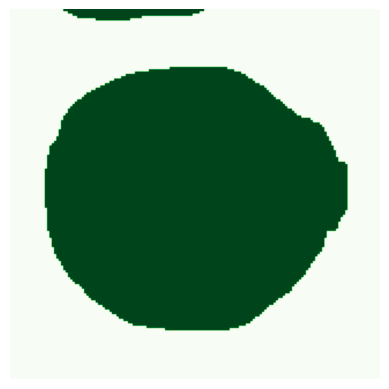

In [77]:
# Find an individual vesicle image
plt.imshow(helpers.sum_masks(dilated_masks, 'segmentation')[int(filtered_masks[0]['bbox'][0]):int(filtered_masks[0]['bbox'][0]+160),int(filtered_masks[0]['bbox'][1]+10):int(filtered_masks[0]['bbox'][1]+170)], cmap="Greens")
plt.axis('off')
plt.savefig("fig2/16294215750158436139_filtered_vesicle_0_dilated_interior_mask.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

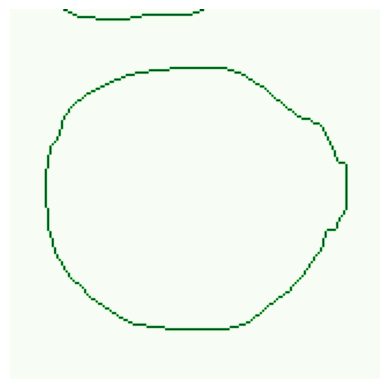

In [78]:
# Find an individual vesicle image
plt.imshow(helpers.sum_masks(dilated_masks, 'edge')[int(filtered_masks[0]['bbox'][0]):int(filtered_masks[0]['bbox'][0]+160),int(filtered_masks[0]['bbox'][1]+10):int(filtered_masks[0]['bbox'][1]+170)], cmap="Greens")
plt.axis('off')
plt.savefig("fig2/16294215750158436139_filtered_vesicle_0_dilated_edge_mask.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

In [40]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.75]])
        img[m] = color_mask
    ax.imshow(img, alpha=0.5)

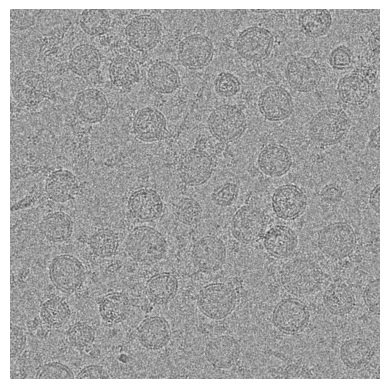

In [80]:
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
#show_anns(filtered_masks)
#ax1.scatter(pick_indices[1], pick_indices[0], marker='x', color='red', s=1, label='original')
#dilated_pick_indices = postprocess.generate_picks(dilated_masks, 1.03, 4, 64, mode='edge')
#ax1.scatter(dilated_pick_indices[1]/4, dilated_pick_indices[0]/4, marker='x', color='green', s=1)
plt.axis('off')
plt.savefig("fig1/16294215750158436139_unannotated.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

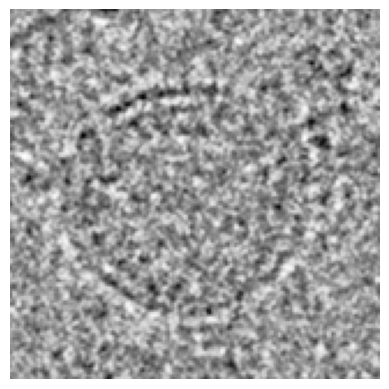

In [39]:
# Just the example vesicle
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph[int(filtered_masks[0]['bbox'][0]):int(filtered_masks[0]['bbox'][0]+160),int(filtered_masks[0]['bbox'][1]+10):int(filtered_masks[0]['bbox'][1]+170)], cmap="Greys_r")
plt.axis('off')
plt.savefig("fig2/16294215750158436139_vesicle_0_unannotated.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

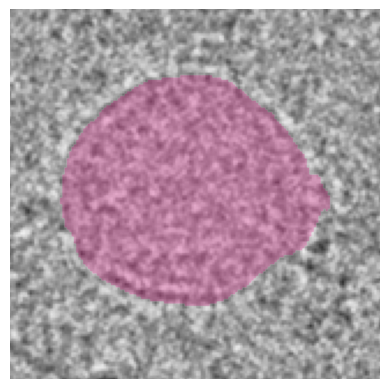

In [50]:
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
show_anns(filtered_masks)
plt.ylim(int(filtered_masks[0]['bbox'][0]),int(filtered_masks[0]['bbox'][0]+160))
plt.xlim(int(filtered_masks[0]['bbox'][1]+10),int(filtered_masks[0]['bbox'][1]+170))

#ax1.scatter(pick_indices[1], pick_indices[0], marker='x', color='red', s=1, label='original')
#dilated_pick_indices = postprocess.generate_picks(dilated_masks, 1.03, 4, 64, mode='edge')
#ax1.scatter(dilated_pick_indices[1]/4, dilated_pick_indices[0]/4, marker='x', color='green', s=1)
plt.axis('off')
plt.savefig("fig2/16294215750158436139_vesicle_0_annotated.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
# Example vesicle
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
show_anns(filtered_masks)
#ax1.scatter(pick_indices[1], pick_indices[0], marker='x', color='red', s=1, label='original')
#dilated_pick_indices = postprocess.generate_picks(dilated_masks, 1.03, 4, 64, mode='edge')
#ax1.scatter(dilated_pick_indices[1]/4, dilated_pick_indices[0]/4, marker='x', color='green', s=1)
plt.axis('off')
plt.savefig("fig1/16294215750158436139_annotated.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

In [78]:
# # ...with pick locations overlaid for comparison
# plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
#                                                            downsample_factor=4, 
#                                                            lowpass_mode = "gaussian",
#                                                            ksize = (3,3),
#                                                      sigmaX=0)
# fig = plt.figure()
# ax1 = fig.add_subplot(111)

# ax1.imshow(plot_micrograph, cmap="Greys_r")
# show_anns(filtered_masks)
# #ax1.scatter(pick_indices[1], pick_indices[0], marker='x', color='red', s=1, label='original')
# dilated_pick_indices = postprocess.generate_picks(dilated_masks, 1.03, 4, 64, mode='edge')
# ax1.scatter(dilated_pick_indices[1]/4, dilated_pick_indices[0]/4, marker='x', color='green', s=1)
# plt.axis('off')
# #plt.savefig("example_micrographs/P199_example_micrographs/annotated_1.png", dpi=600, bbox_inches="tight", pad_inches=0)
# plt.show()

In [ ]:
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
#show_anns(filtered_masks)
#ax1.scatter(pick_indices[1], pick_indices[0], marker='x', color='red', s=1, label='original')
dilated_pick_indices = postprocess.generate_picks(dilated_masks, 1.03, 4, 96, mode='edge')
ax1.scatter(dilated_pick_indices[1]/4, dilated_pick_indices[0]/4, marker='x', color='green', s=1)
plt.axis('off')
plt.savefig("fig2/16294215750158436139_dilated_edge_picks.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

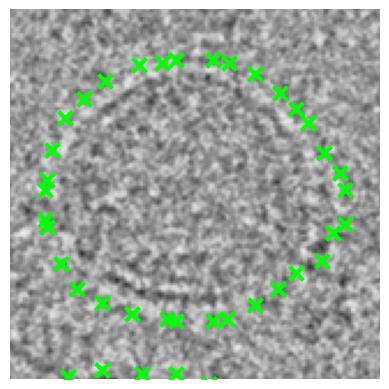

In [80]:
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
#show_anns(filtered_masks)
#ax1.scatter(pick_indices[1], pick_indices[0], marker='x', color='red', s=1, label='original')
dilated_pick_indices = postprocess.generate_picks(dilated_masks, 1.03, 4, 96, mode='edge')
ax1.scatter(dilated_pick_indices[1]/4, dilated_pick_indices[0]/4, marker='x', color='lime', s=100, linewidths=3)

plt.ylim(int(filtered_masks[0]['bbox'][0]),int(filtered_masks[0]['bbox'][0]+160))
plt.xlim(int(filtered_masks[0]['bbox'][1]+10),int(filtered_masks[0]['bbox'][1]+170))

plt.axis('off')
plt.savefig("fig2/16294215750158436139_dilated_edge_picks_vesicle_0.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

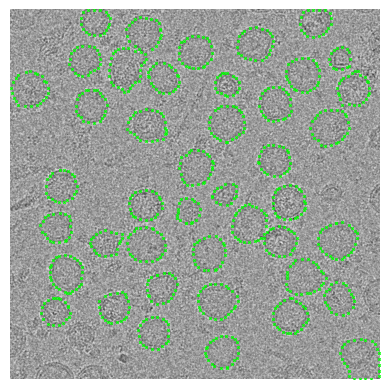

In [21]:
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
#show_anns(filtered_masks)
pick_indices = postprocess.generate_picks(filtered_masks, 1.03, 4, 96, mode='edge')
ax1.scatter(pick_indices[1]/4, pick_indices[0]/4, marker='x', color='lime', s=3, linewidths=0.8)
plt.axis('off')
plt.savefig("fig2/16294215750158436139_edge_picks.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

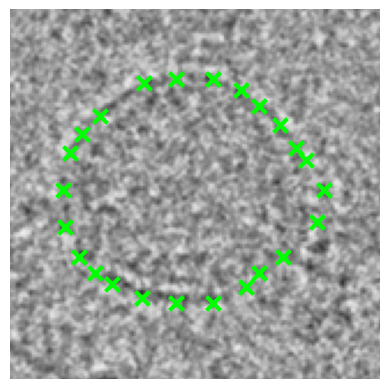

In [64]:
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
#show_anns(filtered_masks)
pick_indices = postprocess.generate_picks(filtered_masks, 1.03, 4, 96, mode='edge')
ax1.scatter(pick_indices[1]/4, pick_indices[0]/4, marker='x', color='lime', s=100, linewidths=3)

plt.ylim(int(filtered_masks[0]['bbox'][0]),int(filtered_masks[0]['bbox'][0]+160))
plt.xlim(int(filtered_masks[0]['bbox'][1]+10),int(filtered_masks[0]['bbox'][1]+170))

plt.axis('off')
plt.savefig("fig2/16294215750158436139_edge_picks_vesicle_0.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

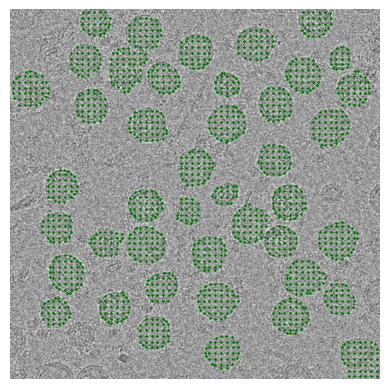

In [97]:
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
#show_anns(filtered_masks)
pick_indices = postprocess.generate_picks(filtered_masks, 1.03, 4, 96, mode='interior')
ax1.scatter(pick_indices[1]/4, pick_indices[0]/4, marker='x', color='green', s=1)
plt.axis('off')
plt.savefig("fig2/16294215750158436139_interior_picks.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()

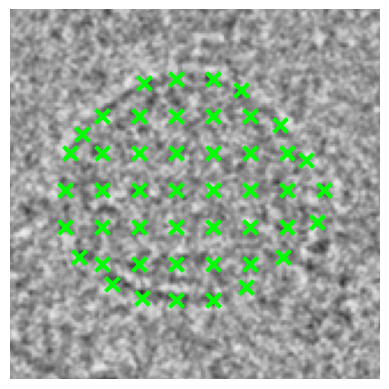

In [63]:
# ...with pick locations overlaid for comparison
plot_micrograph = preprocess.preprocess_micrograph(image_fullres, 
                                                           downsample_factor=4, 
                                                           lowpass_mode = "gaussian",
                                                           ksize = (3,3),
                                                     sigmaX=0)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.imshow(plot_micrograph, cmap="Greys_r")
#show_anns(filtered_masks)
pick_indices = postprocess.generate_picks(filtered_masks, 1.03, 4, 96, mode='interior')
ax1.scatter(pick_indices[1]/4, pick_indices[0]/4, marker='x', color='lime', s=100, linewidths=3)

plt.ylim(int(filtered_masks[0]['bbox'][0]),int(filtered_masks[0]['bbox'][0]+160))
plt.xlim(int(filtered_masks[0]['bbox'][1]+10),int(filtered_masks[0]['bbox'][1]+170))

plt.axis('off')
plt.savefig("fig2/16294215750158436139_interior_picks_vesicle_0.png", dpi=600, bbox_inches="tight", pad_inches=0)
plt.show()